## Get the data
Downloads free daily candle info from cryptodatadownload.com. You only need to run this to pull new daily candle data.
License: https://creativecommons.org/licenses/by-nc-sa/4.0/

In [20]:
# Download the data and remove first line
!curl -L -o ./Bitstamp_BTCUSD_d.csv https://www.cryptodatadownload.com/cdd/Bitstamp_BTCUSD_d.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  384k  100  384k    0     0   215k      0  0:00:01  0:00:01 --:--:--  215k


In [21]:
!sed -i '1d' ./Bitstamp_BTCUSD_d.csv

## Calculate basic statistics
Define start date to filter out earlier data.

In [22]:
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
# plot the daily volatility
import matplotlib.pyplot as plt

start_date = '2020-10-01'

data = pd.read_csv('./Bitstamp_BTCUSD_d.csv')
data['date'] = pd.to_datetime(data['date'])
data = data[::-1]  # Reverse the data order
recent_data = data.loc[data['date'] >= start_date].copy()


recent_data['daily_return'] = recent_data['close'].pct_change()


# Remove rows with NaN values in 'daily_return'
recent_data.dropna(subset=['daily_return'], inplace=True)
# Calculate basic statistics
mean_return = recent_data['daily_return'].mean()
std_dev = recent_data['daily_return'].std()
annualized_volatility = std_dev * np.sqrt(365)  # Assuming 365 period
annualized_return = (1 + mean_return)**365 - 1  # Compound annual return

# Calculate additional metrics
# Sharpe Ratio (assuming risk-free rate of 0 for simplicity)
sharpe_ratio = (mean_return / std_dev) * np.sqrt(365)

# Maximum Drawdown
cumulative_returns = (1 + recent_data['daily_return']).cumprod()
peak = cumulative_returns.expanding().max()
drawdown = (cumulative_returns / peak) - 1
max_drawdown = drawdown.min()

# Win Rate
win_rate = len(recent_data[recent_data['daily_return'] > 0]) / len(recent_data)

# Value at Risk (95% confidence)
var_95 = np.percentile(recent_data['daily_return'], 5)

metrics = {
    "Metric": [
        "Mean Daily Return",
        "Daily Volatility",
        "Annualized Volatility",
        "Annualized Return",
        "Sharpe Ratio",
        "Maximum Drawdown",
        "Win Rate",
        "Value at Risk (95%)"
    ],
    "Value": [
        f"{mean_return*100:.2f}%",
        f"{std_dev:.6f}",
        f"{annualized_volatility:.6f}",
        f"{annualized_return*100:.2f}%",
        f"{sharpe_ratio:.6f}",
        f"{max_drawdown*100:.2f}%",
        f"{win_rate*100:.2f}%",
        f"{var_95:.6f}"
    ]
}

summary_table = pd.DataFrame(metrics)
markdown_output = summary_table.to_markdown(index=False)

print(f"Basic Data Information since {start_date}:")
display(Markdown(markdown_output))

Basic Data Information since 2020-10-01:


| Metric                | Value     |
|:----------------------|:----------|
| Mean Daily Return     | 0.16%     |
| Daily Volatility      | 0.030820  |
| Annualized Volatility | 0.588812  |
| Annualized Return     | 79.76%    |
| Sharpe Ratio          | 0.996759  |
| Maximum Drawdown      | -76.66%   |
| Win Rate              | 50.75%    |
| Value at Risk (95%)   | -0.046802 |

### Plot the volatility
This section examines **short-term price movement and risk** in Bitcoin by plotting daily returns, defined as the percentage change in closing price from one day to the next. The daily returns chart highlights volatility clustering, extreme moves, and shifts in market behavior.

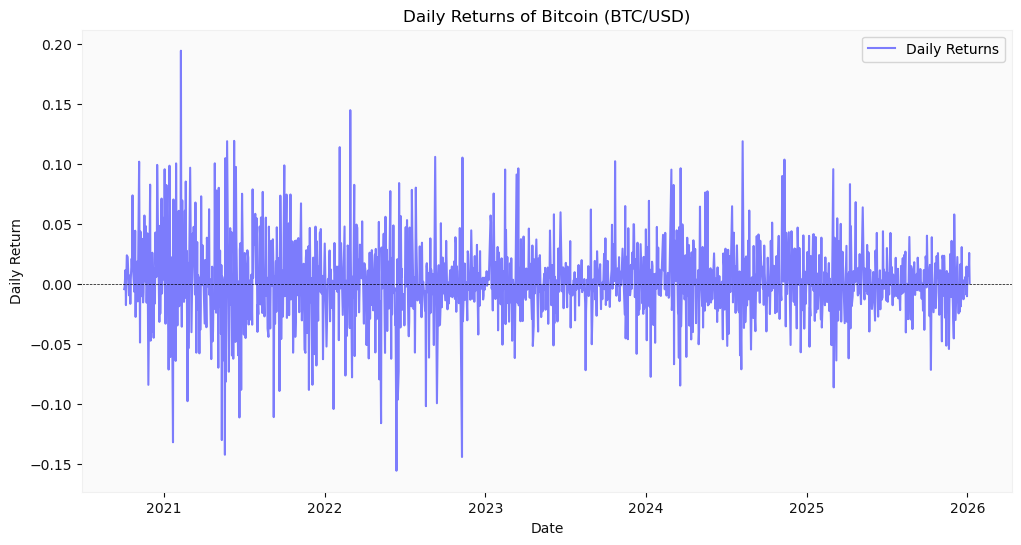

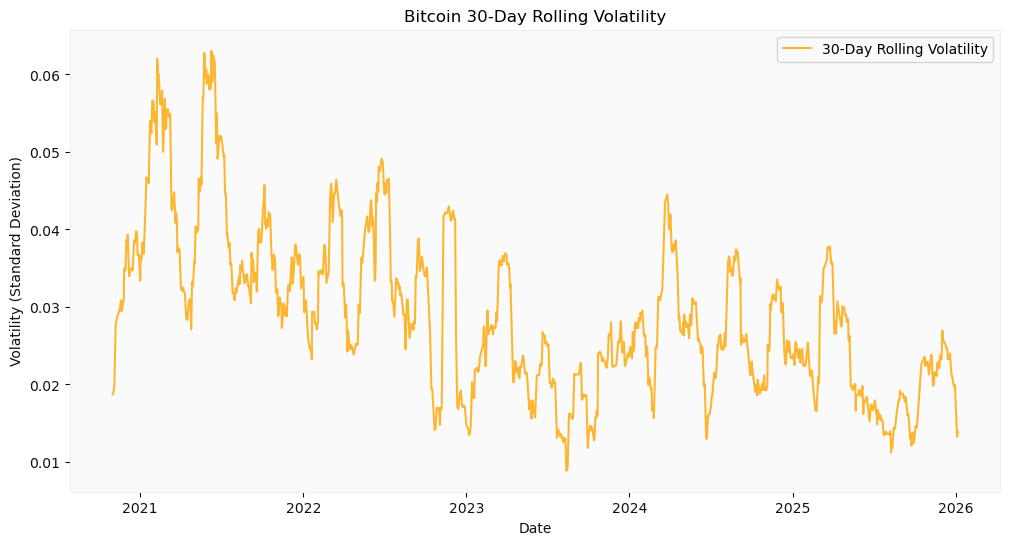

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(recent_data['date'], recent_data['daily_return'], label='Daily Returns', color='blue', alpha=0.5)
plt.title('Daily Returns of Bitcoin (BTC/USD)')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.legend()
plt.grid()
plt.show()

# Calculate rolling volatility (standard deviation) over a 30-day window
recent_data['rolling_volatility'] = recent_data['daily_return'].rolling(window=30).std()

# Plot the rolling volatility
plt.figure(figsize=(12, 6))
plt.plot(recent_data['date'], recent_data['rolling_volatility'], label='30-Day Rolling Volatility', color='orange', alpha=0.8)
plt.title('Bitcoin 30-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility (Standard Deviation)')
plt.legend()
plt.grid()
plt.show()

In [24]:
# Display data summary
print("\nData Summary:")
print(recent_data[['close','Volume BTC', 'daily_return', 'rolling_volatility']].describe())


Data Summary:
               close    Volume BTC  daily_return  rolling_volatility
count    1923.000000   1923.000000   1923.000000         1894.000000
mean    52764.449059   2857.424509      0.001608            0.029061
std     29893.422563   3103.774189      0.030820            0.010563
min     10553.660000      3.567446     -0.155526            0.008876
25%     27958.500000   1264.046703     -0.012679            0.021235
50%     44184.000000   1987.576786      0.000310            0.027508
75%     68253.500000   3154.248017      0.015007            0.035531
max    124728.000000  40786.964254      0.194503            0.063060


## Simple closing prices line with EMA

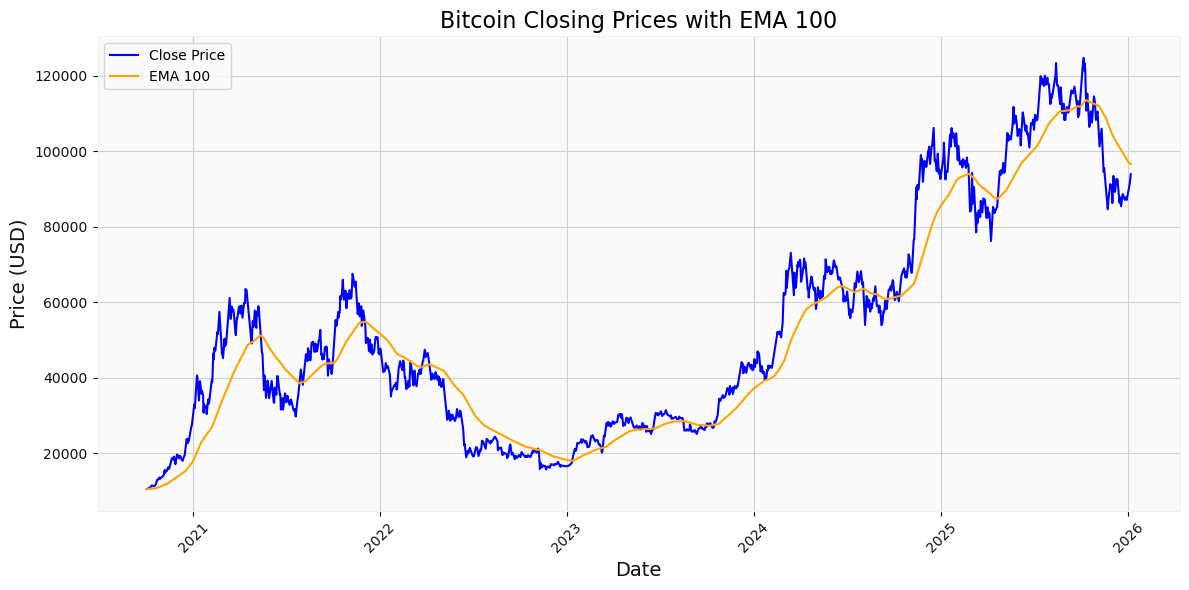

In [25]:
recent_data['EMA_100'] = recent_data['close'].ewm(span=100, adjust=False).mean()

plt.figure(figsize=(12, 6))

# Plot close prices
plt.plot(recent_data['date'], recent_data['close'], label='Close Price', color='blue')

# Plot EMA
plt.plot(recent_data['date'], recent_data['EMA_100'], label='EMA 100', color='orange')

# titles and labels
plt.title('Bitcoin Closing Prices with EMA 100', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

## Display PSAR, RSI, and EMA

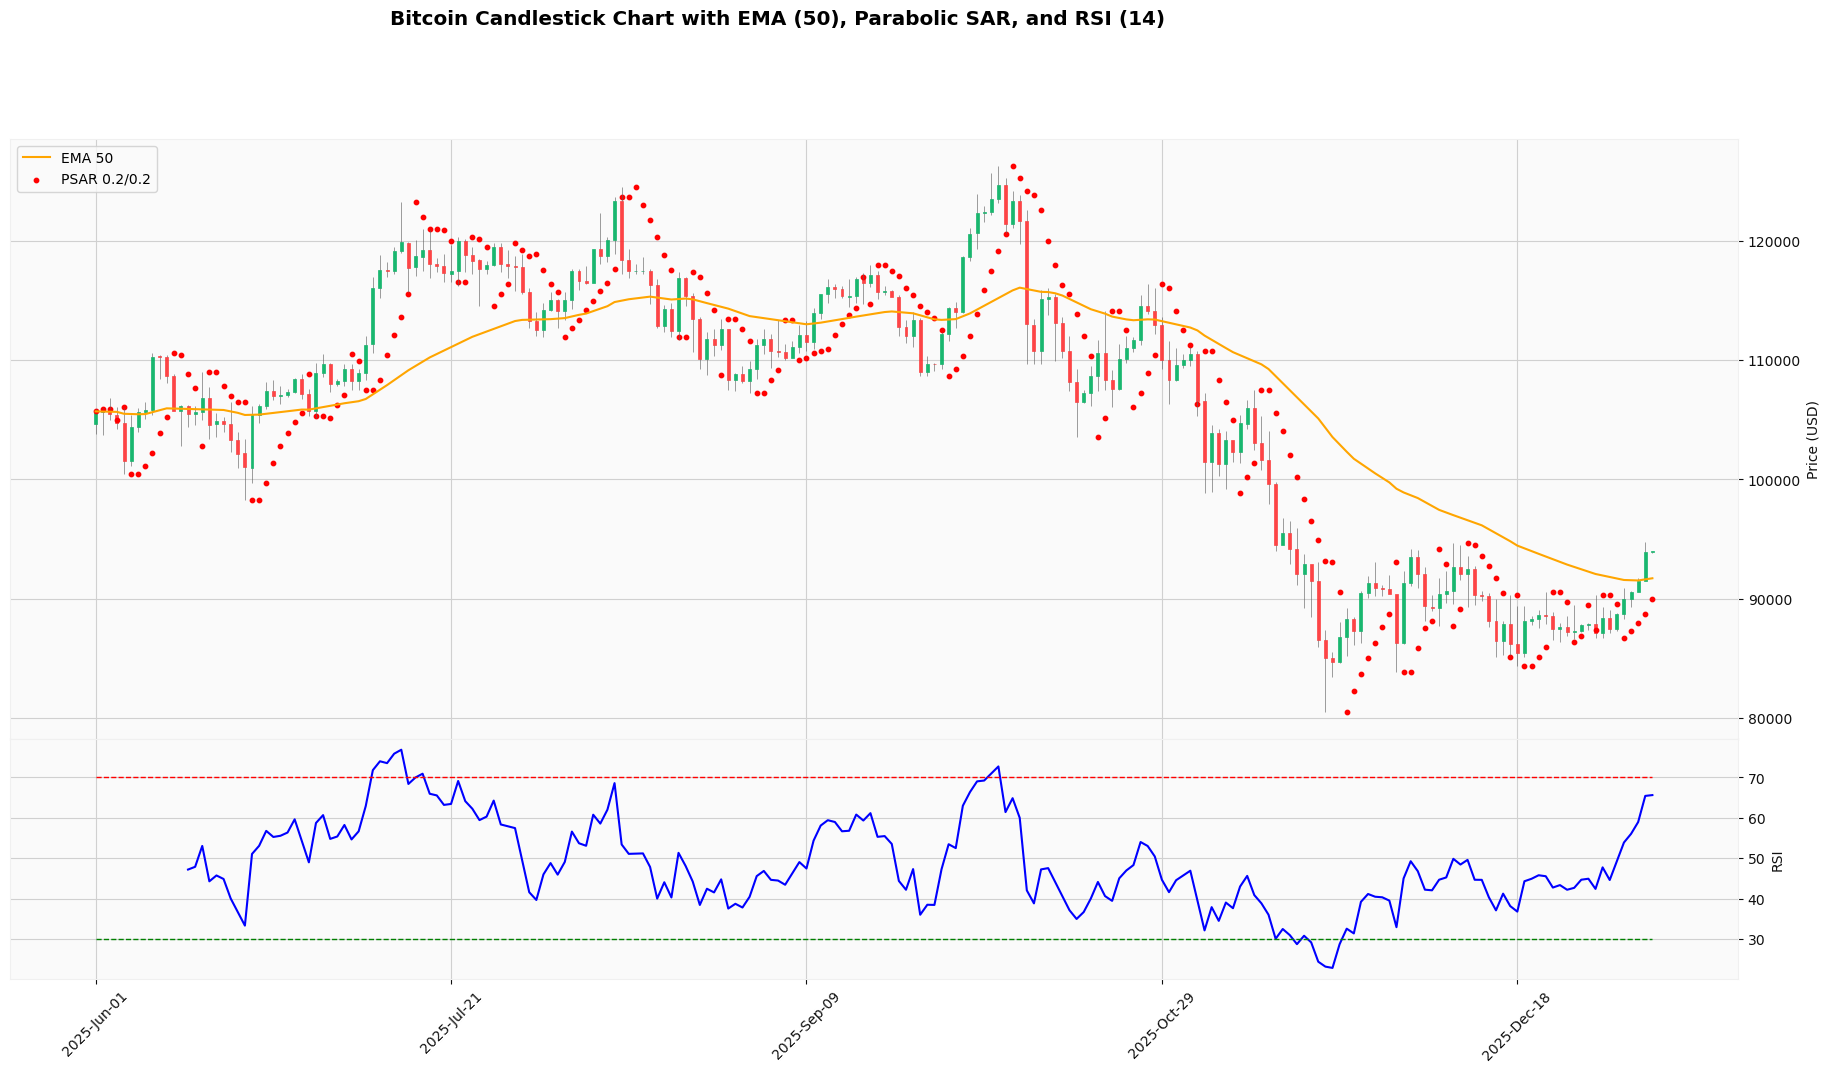

In [26]:
import mplfinance as mpf
from ta.trend import PSARIndicator
from ta.momentum import RSIIndicator
import warnings



ema_span = 50
psar_step = 0.2 # Default acceleration factor
psar_max = 0.2 # Default maximum acceleration factor
rsi_period = 14
start_date = '2025-06-01'  # Define the start date for filtering


warnings.filterwarnings("ignore", category=FutureWarning)

#Read and sort the data
data = pd.read_csv('./Bitstamp_BTCUSD_d.csv')
data['date'] = pd.to_datetime(data['date'])
data = data[::-1]  # Reverse the data order

data = data[data['date'] >= start_date] # Remove data before the start date

# set'date' column as the index (required for mplfinance)
data.set_index('date', inplace=True)


# calculate EMA
data[f'EMA_{ema_span}'] = data['close'].ewm(span=ema_span, adjust=False).mean()

psar = PSARIndicator(
    high=data['high'],
    low=data['low'],
    close=data['close'],
    step=psar_step,
    max_step=psar_max
)
data['psar'] = psar.psar()

# calculate RSI
data['RSI_upper'] = 70 # Overbought threshold
data['RSI_lower'] = 30 # Oversold threshold
rsi = RSIIndicator(close=data['close'], window=rsi_period)
data['RSI'] = rsi.rsi()

# prepare the additional EMA, PSAR overlays, and RSI subplot for mplfinance
additional_plots = [
    mpf.make_addplot(data[f'EMA_{ema_span}'], color='orange', width=1.5, label=f'EMA {ema_span}'),
    mpf.make_addplot(data['psar'], color='red', scatter=True, markersize=10, label=f'PSAR {psar_step}/{psar_max}'),
    mpf.make_addplot(data['RSI'], panel=1, color='blue', width=1.5, ylabel='RSI'),  # Add RSI as a subplot
    mpf.make_addplot(data['RSI_upper'], panel=1, color='red', width=1, linestyle='--'),
    mpf.make_addplot(data['RSI_lower'], panel=1, color='green', width=1, linestyle='--')
]

# plot candlesticks
fig, axlist = mpf.plot(
    data,
    type='candle',
    style='yahoo',
    addplot=additional_plots,
    title=f'Bitcoin Candlestick Chart with EMA ({ema_span}), Parabolic SAR, and RSI ({rsi_period})',
    ylabel='Price (USD)',
    figsize=(24, 12),
    volume=False,  # Set to True if you want a volume subplot
    returnfig=True  # Required to modify legend position
)

# adjust legend position to upper left
for ax in axlist:
    handles, labels = ax.get_legend_handles_labels()
    if handles:  # Check if there are any handles to avoid errors
        ax.legend(handles, labels, loc='upper left')  # Move legend to top left



## Halving cycle comparison
This chart compares Bitcoin price performance across halving cycles by aligning each cycle to a common reference point and expressing price changes as cumulative percentage returns. Rather than being fixed to the calendar halving date, the analysis allows the starting point to be shifted earlier or later using the `shifted_days` parameter. This makes it possible to test different alignment theories.

Prices are normalized to the closing price on the selected “day 0,” defined by the halving date plus the configured shift, so all cycles begin at 0%. This normalization removes absolute price differences between cycles and isolates relative performance over time. By adjusting the shift and observing how peak timing and return profiles change, the chart can be used to explore post-halving behavior and to evaluate whether observed similarities between cycles are robust.

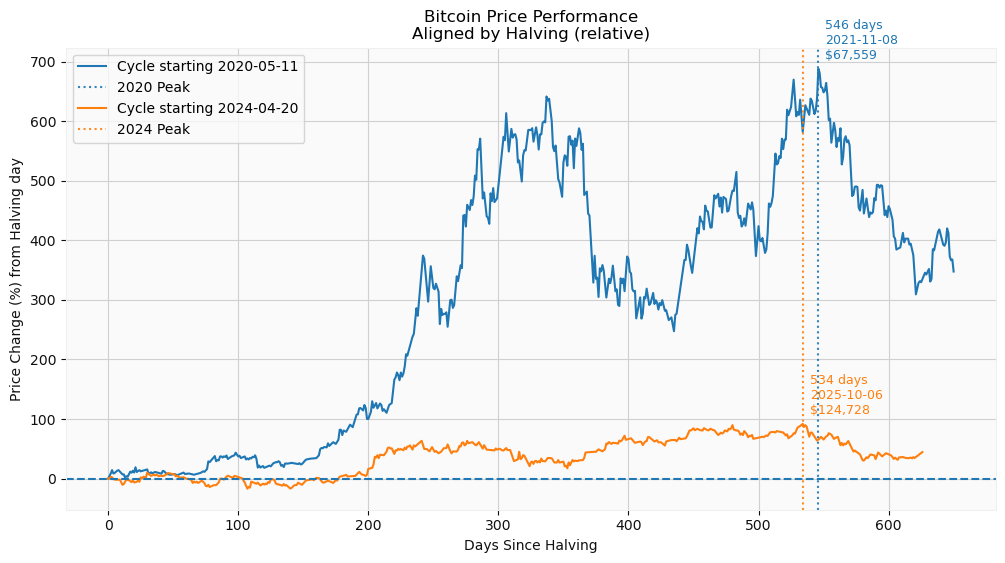

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# configuration
# ============================================================

selected_halvings = ["2020", "2024"]  # Select which halving cycles to include
max_days_since_halving = 650  # Days to include in the chart
shifted_days = 0 # Shift all halving dates


halving_dates = {
    # "2012": pd.Timestamp("2012-11-28"),  # no data available
    "2016": pd.Timestamp("2016-07-09"),
    "2020": pd.Timestamp("2020-05-11"),
    "2024": pd.Timestamp("2024-04-20"),
}

figure_size_inches = (12, 6)
data_path = "./Bitstamp_BTCUSD_d.csv"
# ============================================================
# data loading
# ============================================================

data = pd.read_csv(data_path)
data["date"] = pd.to_datetime(data["date"])
data = data.sort_values("date")
data.set_index("date", inplace=True)

# ============================================================
# transformations
# ============================================================

def build_halving_cycle(
    price_data: pd.DataFrame,
    halving_date: pd.Timestamp,
    shifted_days: int,
    max_days: int,
) -> pd.DataFrame:
    effective_start_date = halving_date + pd.Timedelta(days=shifted_days)

    cycle = price_data.loc[price_data.index >= effective_start_date].copy()

    cycle["days_since_halving"] = (cycle.index - effective_start_date).days
    cycle = cycle[(cycle["days_since_halving"] >= 0) &
                  (cycle["days_since_halving"] <= max_days)]

    cycle.set_index("days_since_halving", inplace=True)

    base_price = cycle.loc[0, "close"]
    cycle["normalized_percent"] = (
        cycle["close"] / base_price - 1.0
    ) * 100.0

    return cycle


cycles = {
    label: build_halving_cycle(
        price_data=data,
        halving_date=halving_dates[label],
        shifted_days=shifted_days,
        max_days=max_days_since_halving,
    )
    for label in selected_halvings
}

# ============================================================
# plotting
# ============================================================

plt.figure(figsize=figure_size_inches)

for label, cycle in cycles.items():
    effective_date = halving_dates[label] + pd.Timedelta(days=shifted_days)

    (cycle_line,) = plt.plot(
        cycle.index,
        cycle["normalized_percent"],
        label=f"Cycle starting {effective_date.date()}",
    )

    # peak in normalized performance
    peak_day = cycle["normalized_percent"].idxmax()
    peak_value = cycle.loc[peak_day, "normalized_percent"]

    # corresponding USD price and calendar date at peak
    peak_price_usd = cycle.loc[peak_day, "close"]
    peak_date = effective_date + pd.Timedelta(days=int(peak_day))

    plt.axvline(
        x=peak_day,
        linestyle=":",
        color=cycle_line.get_color(),
        label=f"{label} Peak",
        alpha=0.9,
    )

    plt.annotate(
        f"{peak_day} days\n{peak_date.date()}\n${peak_price_usd:,.0f}",
        xy=(peak_day, peak_value),
        xytext=(5, 5),
        textcoords="offset points",
        color=cycle_line.get_color(),
        fontsize=9,
        ha="left",
        va="bottom",
    )
    if shifted_days != 0:
        plt.annotate(
            f"Shifted by {shifted_days} days",
            xy=(max_days_since_halving * 0.7, -20),
            color="gray",
            fontsize=9,
        )

title = "Bitcoin Price Performance\nAligned by Halving (relative)"
if shifted_days != 0:
    title += f" \n(Halving date shifted by {shifted_days} days)"

plt.axhline(0, linestyle="--")
plt.title(title)
plt.xlabel("Days Since Halving")
plt.ylabel("Price Change (%) from Halving day")
plt.legend()
plt.show()


## Save the chart to file

In [29]:
# save output .png
output_file = f'bitcoin_candlestick_chart_ema{ema_span}_rsi{rsi_period}.png'
fig.savefig(output_file)

print(f"Chart saved as {output_file}")


Chart saved as bitcoin_candlestick_chart_ema50_rsi14.png
